# Imports

In [2]:
import json
import os
import warnings 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
warnings.filterwarnings('ignore')

# Data

Data should be in CSV format, with two DataFrames required: one containing data from low-cost sensors and another with data from the reference device. Both DataFrames need to have the same column names. The timestamp is usually an object, so we’ll convert it to datetime format here.

In [ ]:
sensor_data = pd.read_csv('path_to_sensor_data.csv')

In [ ]:
referent_data = pd.read_csv('path_to_referent_data.csv')

### Pick targets you want model to be trained for

In [4]:
targets = ['CO2', 'TVOC', 'CO', 'PM1', 'PM25', 'PM10', 'temperature',
       'humidity', 'atmospheric_pressure']

# Data preprocessing

In [6]:
def fixing_timestamps(df):
    
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    df = df.resample('30T').mean()
    
    return df

In [7]:
def removing_nans(df):
    return df.dropna()

In [8]:
sensor_data = fixing_timestamps(sensor_data)
referent_data = fixing_timestamps(referent_data)

In [9]:
sensor_data = removing_nans(sensor_data)
referent_data = removing_nans(referent_data)

# Model initialization

In [10]:
rf = RandomForestRegressor()

# Hyperparametar optimization

First, select the hyperparameters and their values for the search.

In [11]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

In [12]:
def spliting_dataset(X, Y, split=0.8):
    
    train_test_split = round(len(X) * split)
    X_train = X[:train_test_split] 
    X_test = X[train_test_split:] 
    Y_train = Y[:train_test_split] 
    Y_test = Y[train_test_split:] 
    
    return X_train, X_test, Y_train, Y_test

In [13]:
def save_hyperparameters(best_params, target, folder_name):
    with open(os.path.join(folder_name,f'{target}_hyperparameters.json'), 'w') as f:
        json.dump(best_params, f, indent=4)

In [14]:
results_folder = "results" #where you want all of your results to be stored

In [15]:
if not os.path.exists(results_folder):
    os.makedirs(results_folder)
    print(f"{results_folder} folder created.")
else:
    print(f"{results_folder} folder already exists, skipping creation.")

results folder created.


In [ ]:
for target in targets: 
    X = sensor_data[[target]]
    Y = referent_data[[target]]
    
    X_train, X_test, Y_train, Y_test = spliting_dataset(X, Y)
    
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, Y_train)
    
    best_params = grid_search.best_params_

    save_hyperparameters(best_params, target, results_folder)

# Model training

In [16]:
def remove_outliers_z_score(df,window_size=3, threshold=3):
    clean_df = pd.DataFrame()
    for column in df.columns: 
        for start in range(0, len(df), window_size):
            end = start + window_size
            window = df[start:end].copy()

            if len(window) == window_size:
                window['z_score'] = (window[column] - window[column].mean()) / window[column].std()
                window_clean = window[np.abs(window['z_score']) < threshold]
                clean_df = pd.concat([clean_df, window_clean.drop(columns=['z_score'])])
        
    clean_df = clean_df.drop_duplicates()
    return clean_df

In [17]:
def load_hyperparameters(target, folder_name):
    with open(os.path.join(folder_name,f'{target}_hyperparameters.json'), 'r') as f:
        hyperparameters = json.load(f)
    return hyperparameters

In [18]:
def fixing_index(df, df_ref):
    
    if len(df) > len(df_ref):
        df = df.reindex(df_ref.index)
    else: 
        df_ref = df_ref.reindex(df.index)
        
    df.index = pd.to_datetime(df['timestamp'])
    df_ref.index = pd.to_datetime(df_ref['timestamp'])
    
    return df, df_ref

In [19]:
def save_results(results_r2, results_rmse, results_corr):
    
    results_r2 = pd.DataFrame.from_dict(results_r2, orient='index', columns=['R2 Score'])
    results_rmse = pd.DataFrame.from_dict(results_rmse, orient='index', columns=['RMSE'])
    results_corr = pd.DataFrame.from_dict(results_corr, orient='index', columns=['Correlation'])
    
    results_df = pd.concat([results_r2, results_rmse, results_corr], axis=1)
    results_df.index = results_df.index.str.replace('^Pred_', 'Prediction_', regex=True).str.replace('^X_', 'Low_Cost_Sensor', regex=True)
    
    return results_df
    

In [20]:
sensor_data = remove_outliers_z_score(sensor_data)
referent_data = remove_outliers_z_score(referent_data)

# This just checks if by removing outliers nan values appered
if sensor_data.isna().sum().sum():
    sensor_data = removing_nans(sensor_data)

if referent_data.isna().sum().sum():
    referent_data = removing_nans(referent_data)

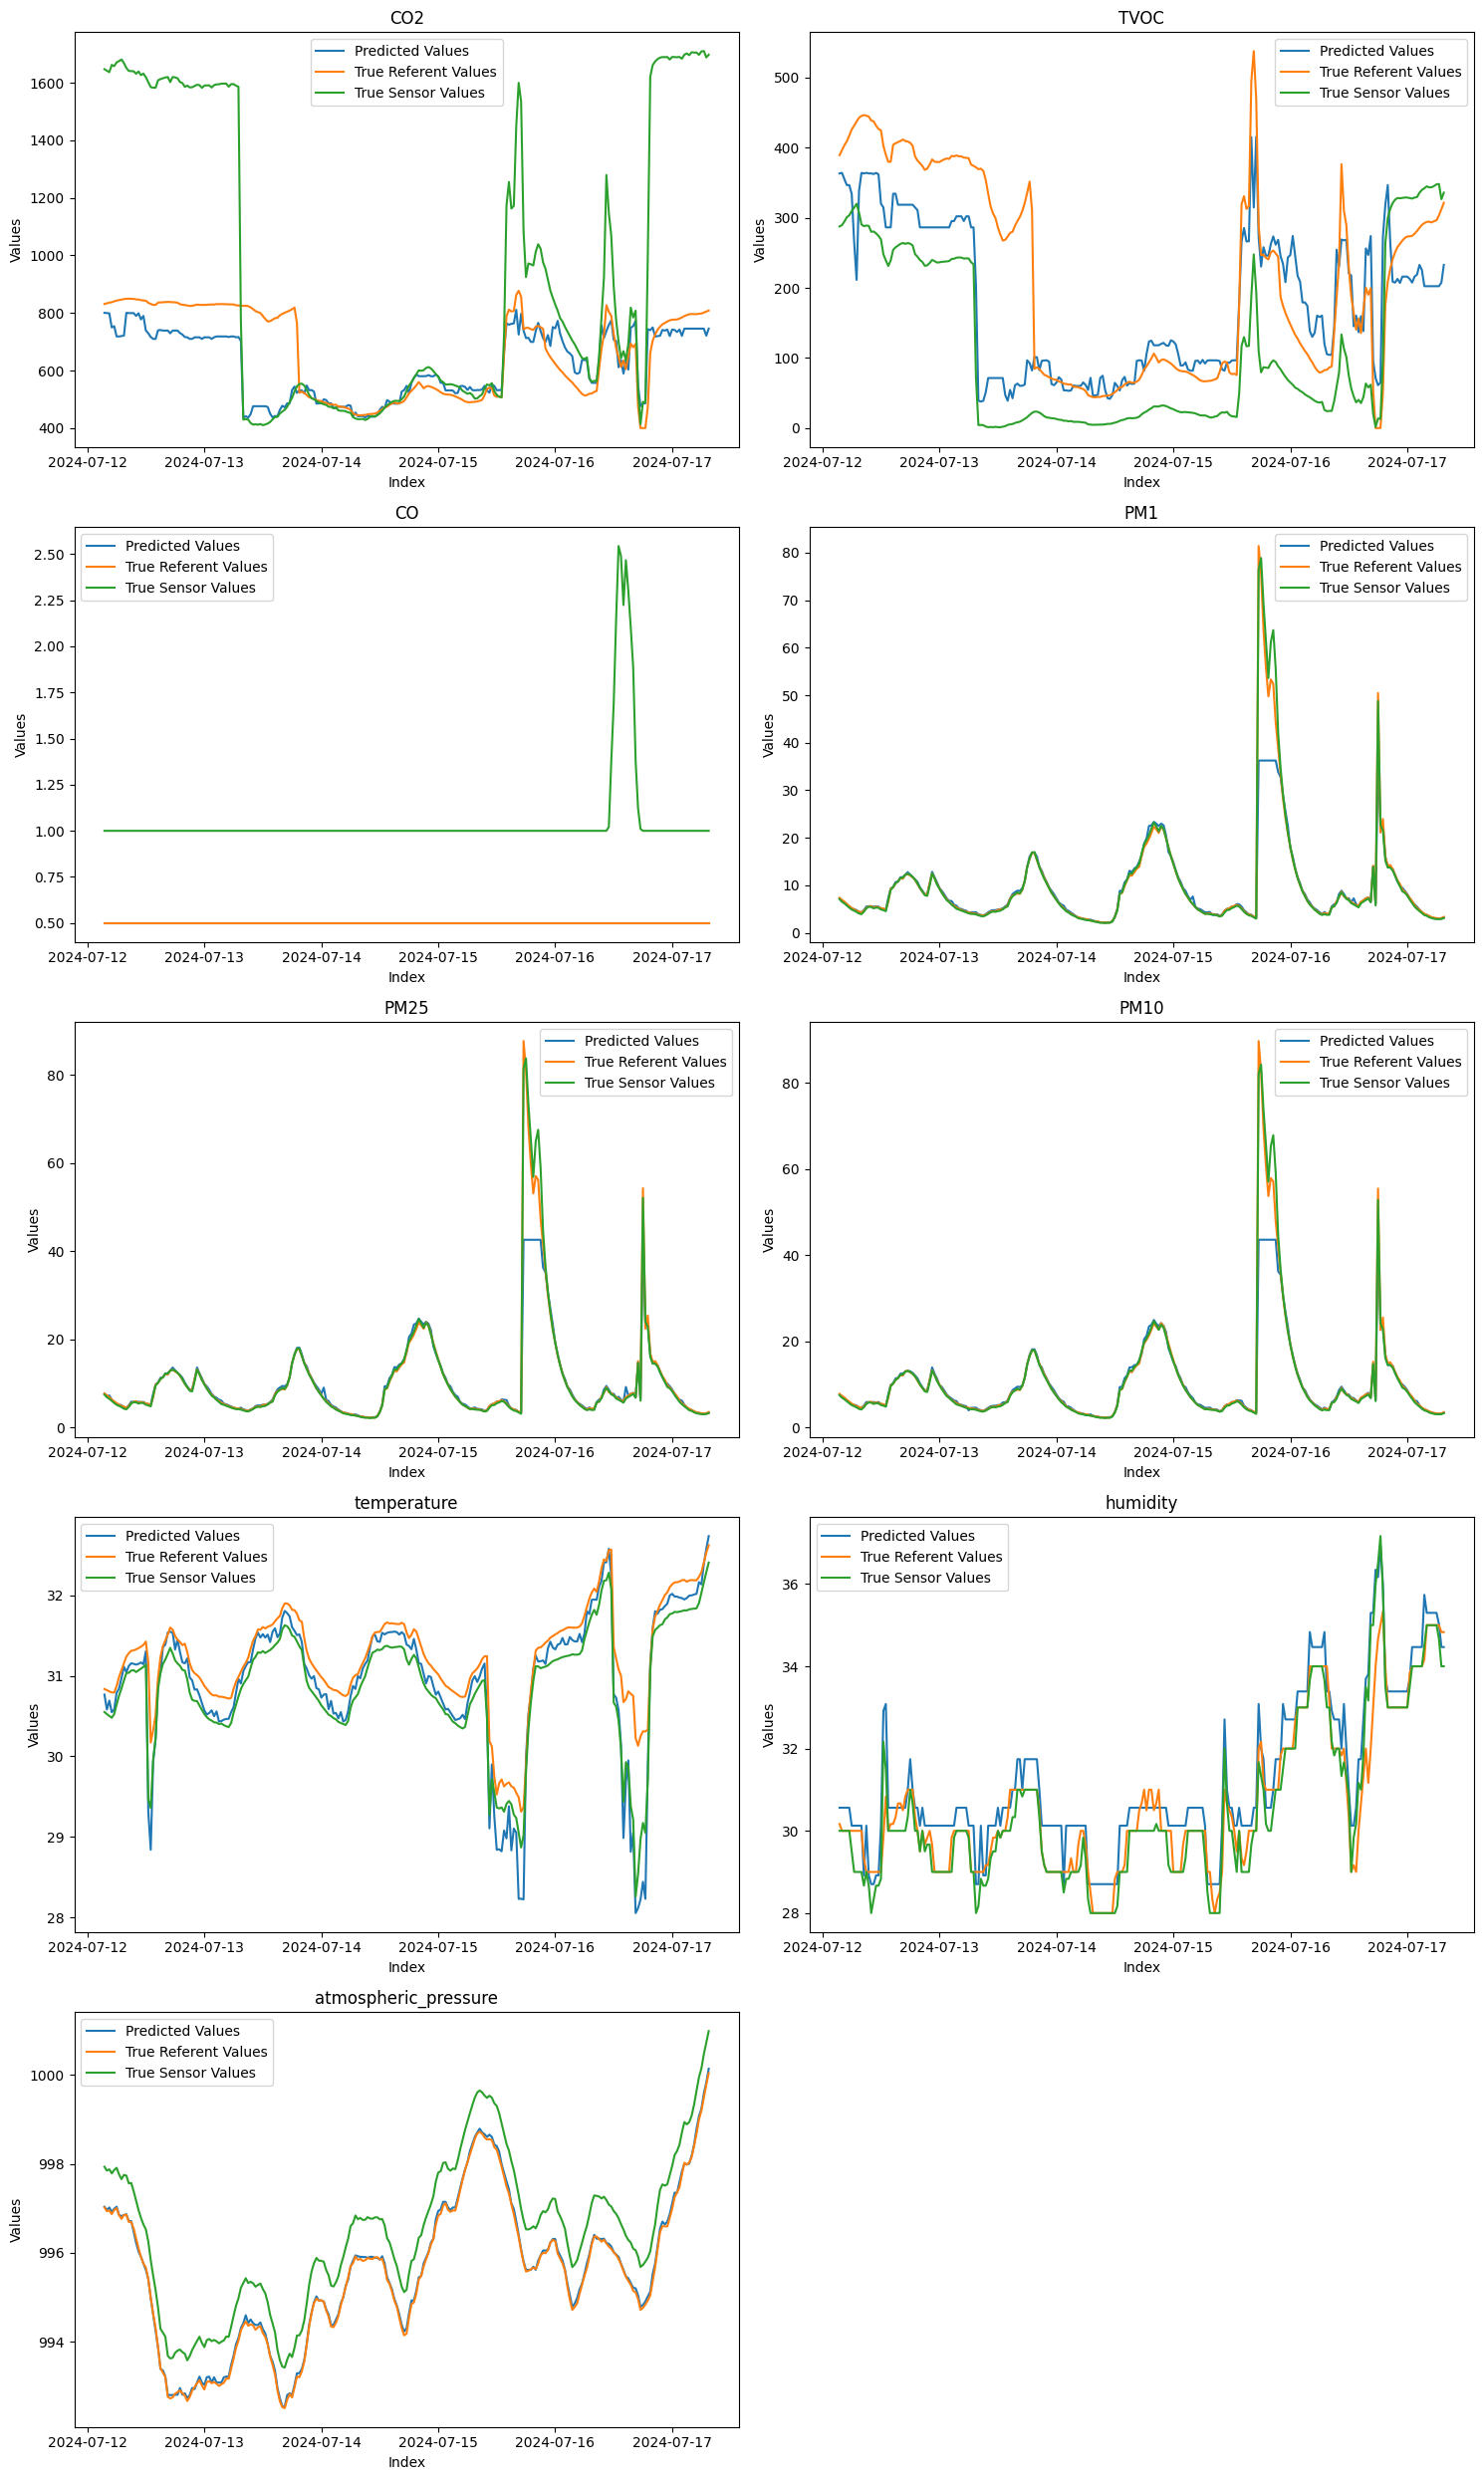

In [21]:
if len(sensor_data) != len(referent_data):
    sensor_data, referent_data = fixing_index(sensor_data, referent_data)

sensor_data.sort_index(inplace=True)
referent_data.sort_index(inplace=True)

# Set up the figure and axes for plotting based on the number of targets
num_targets = len(targets)
num_rows = (num_targets + 1) // 2  # Calculate rows needed, 2 columns
fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))
fig.subplots_adjust(top=0.9)
axes = axes.flatten()  # Flatten to easily iterate over axes

# Initialize result dictionaries
temp_results_r2 = {}
temp_results_rmse = {}
temp_results_correlation = {}

# Iterate over each target variable
for i, target in enumerate(targets):
    X = sensor_data[[target]]
    Y = referent_data[[target]]
    X_train, X_test, Y_train, Y_test = spliting_dataset(X, Y)
    
    # Load hyperparameters and fit the model
    hyperparameters = load_hyperparameters(target, results_folder)
    rf = RandomForestRegressor(**hyperparameters)
    rf.fit(X_train, Y_train)
    
    # Predictions and metrics calculation
    y_pred = rf.predict(X_test)
    
    temp_results_r2[f'Pred_{target}'] = r2_score(Y_test, y_pred)
    temp_results_r2[f'X_{target}'] = r2_score(Y_test, X_test)
    temp_results_rmse[f'Pred_{target}'] = mean_squared_error(Y_test, y_pred)
    temp_results_rmse[f'X_{target}'] = mean_squared_error(Y_test, X_test)

    # Plotting
    ax = axes[i]
    ax.plot(Y_test.index, y_pred, label='Predicted Values')
    ax.plot(Y_test.index, Y_test, label='True Referent Values')
    ax.plot(Y_test.index, X_test, label='True Sensor Values')
    
    ax.set_title(f'{target}')
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.legend()

    # Calculate correlations
    Y_test.rename(columns={target: f'Y_{target}'}, inplace=True)
    X_test.rename(columns={target: f'X_{target}'}, inplace=True)
    Pred = pd.DataFrame(y_pred, columns=[f'Pred_{target}'], index=Y_test.index)

    temp_df = pd.concat([Y_test, X_test, Pred], axis=1)
    temp_results_correlation[f'X_{target}'] = temp_df.corr().loc[f'Y_{target}', f'X_{target}']
    temp_results_correlation[f'Pred_{target}'] = temp_df.corr().loc[f'Y_{target}', f'Pred_{target}']
    
for j in range(num_targets, len(axes)):
    fig.delaxes(axes[j])  # Delete unused axes

# Save results DataFrame
save_results_df = save_results(temp_results_r2, temp_results_rmse, temp_results_correlation)
save_results_df.to_csv(os.path.join(results_folder, 'results_df.csv'))

# Save and show plot
plt.tight_layout()
plt.savefig(os.path.join(results_folder, 'results_plot.png'))
plt.show()